## Solving an RBC Model by Perturbation with DifferentiableStateSpaceModels.jl

The following notebook implements and solves the RBC model used as [example 1](https://www.dynare.org/assets/tutorial/example1.mod) in the official introductory [Dynare tutorial](https://www.dynare.org/assets/tutorial/guide.pdf), via the library [DifferentiableStateSpaceModels.jl](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl), which provides a native Julia implementation. See the tutorial for model details, and the [DifferentiableStateSpaceModels.jl intro example notebook](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl/blob/main/notebooks/estimate_rbc.ipynb) for DSSM implementation details. As a practical matter, DSSM uses the Schmitt-Grohe and Uribe notation conventions (see the [Handbook of Macroeconomics chapter](https://www.sas.upenn.edu/~jesusfv/FVRS_Handbook.pdf)) while Dynare has its own slightly different syntax.

In [1]:
import Pkg; 
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Library/CloudStorage/Dropbox/Computational Methods/Code/Julia/Perturbation`


In [2]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, Plots, DiffEqBase, Symbolics, BenchmarkTools

In [3]:
# Model Declaration and setup
∞ = Inf
@variables β, ρ, α, δ, θ, ψ, τ, σe, σu, ϕ
@variables t::Integer, GDP(..), c(..), k(..), a(..), h(..), b(..)

x = [k, a, b] # states
y = [c, GDP, h] # controls
p = [β, ρ, α, δ, θ, ψ, τ, σe, σu, ϕ] # parameters

H = [c(t) * θ * h(t)^(1 + ψ) - (1 - α) * GDP(t),
    β * (((exp(b(t)) * c(t)) / (exp(b(t+1)) * c(t+1))) * (exp(b(t+1)) * α * GDP(t+1) + (1 - δ) * k(t))) - k(t), 
    GDP(t) - exp(a(t)) * (k(t)^α) * (h(t)^(1 - α)),
    k(t+1) - exp(b(t)) * (GDP(t) - c(t)) - (1 - δ) * k(t),
    a(t+1) - ρ * a(t) - τ * b(t),
    b(t+1) - τ * a(t) - ρ * b(t)]  # system of model equations

steady_states_iv = [k(∞) ~ 11.08360443260358,
    a(∞) ~ 0,
    b(∞) ~ 0,
    c(∞) ~ 0.80359242014163,
    GDP(∞) ~ 1.08068253095672,
    h(∞) ~ 0.29175631001732]

n_ϵ = 2
n_x = length(x)
n_y = length(y)
Γ = zeros(Num, n_ϵ, n_ϵ) # make sure it is not a float64 matrix
Γ[1, 1] = σe
Γ[2, 2] = σu
Γ[1, 2] = ϕ*σe*σu
Γ[2, 1] = ϕ*σe*σu
η = zeros(n_x, n_ϵ) # η is n_x * n_ϵ matrix
η[2, 1] = 1 # e
η[3, 2] = 1 # u

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache  = true
rbcmodel = @make_and_include_perturbation_model("example1rbc", H, (; t, y, x, p, steady_states_iv, Γ, η, overwrite_model_cache)) # Convenience macro.  Saves as ".function_cache/example1rbc.jl"
#Following code splits above result into steps to be performed manually
#examplemodel = make_perturbation_model(H; t, y, x, steady_states_iv, Γ, η, p, model_name="myrbcexample")
#include("/Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/myrbcexample.jl")
#rbcmodel = PerturbationModel(Main.myrbcexample)

Perturbation Model: n_y = 3, n_x = 3, n_p = 10, n_ϵ = 2, n_z = 6
 y = [:c, :GDP, :h] 
 x = [:k, :a, :b] 
 p = [:β, :ρ, :α, :δ, :θ, :ψ, :τ, :σe, :σu, :ϕ]

In [4]:
model_H_latex(rbcmodel) #Show model equations

"\$\\begin{equation}\n\\left[\n\\begin{array}{c}\n - \\left( 1 - \\alpha \\right) \\mathrm{GDP}\\left( t \\right) + \\left( h\\left( t \\right) \\right)^{1 + \\psi} \\theta c\\left( t \\right) \\\\\n\\frac{\\beta \\left( \\left( 1 - \\delta \\right) k\\left( t \\right) + \\alpha \\mathrm{GDP}\\left( 1 + t " ⋯ 389 bytes ⋯ "GDP}\\left( t \\right) \\right) e^{b\\left( t \\right)} + k\\left( 1 + t \\right) \\\\\n - \\rho a\\left( t \\right) - \\tau b\\left( t \\right) + a\\left( 1 + t \\right) \\\\\n - \\tau a\\left( t \\right) - \\rho b\\left( t \\right) + b\\left( 1 + t \\right) \\\\\n\\end{array}\n\\right]\n\\end{equation}\n\$"

In [5]:
p_f = (β = 0.99, α = 0.36, δ = 0.025, θ = 2.95, ψ = 0, σe = 0.009, σu = 0.009, ϕ = 0.1) # fixed parameters
p_d = (ρ = 0.95, τ = 0.025); # differentiated parameters (used if estimating model, otherwise same as above)

In [6]:
sol = generate_perturbation(rbcmodel, p_d, p_f) # Solution to the first-order RBC
sol_2 = generate_perturbation(rbcmodel, p_d, p_f, Val(2)); # Solution to the second-order RBC
@show sol.retcode, sol_2.retcode

(sol.retcode, sol_2.retcode) = (:Success, :Success)


(:Success, :Success)

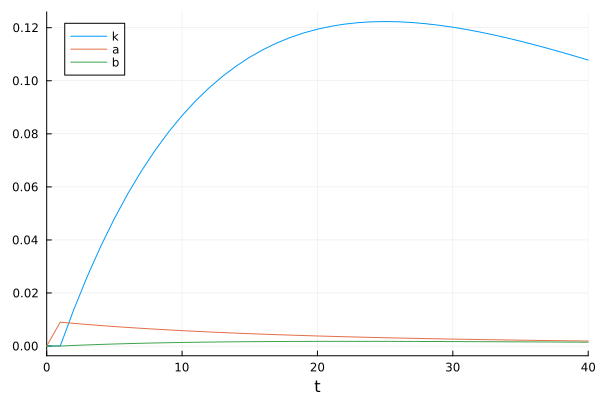

In [7]:
#Construct IRFs
eshock = [1, 0]
ushock = [0, 1]
T = 40
eirforder1 = irf(sol, eshock, T)
plot(eirforder1) #State variables only

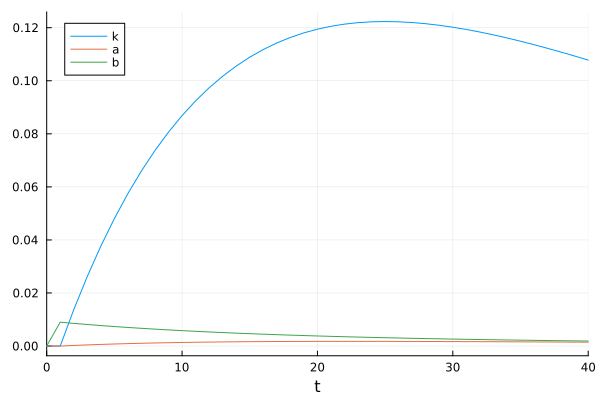

In [8]:
uirforder1 = irf(sol, ushock, T)
plot(uirforder1) #State variables only

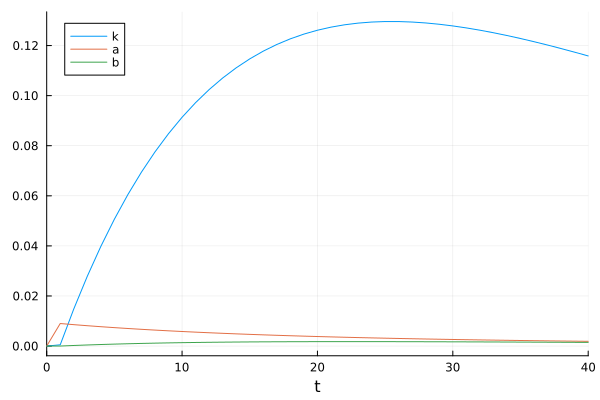

In [9]:
eirforder2 = irf(sol_2, eshock, T)
plot(eirforder2) #State variables only

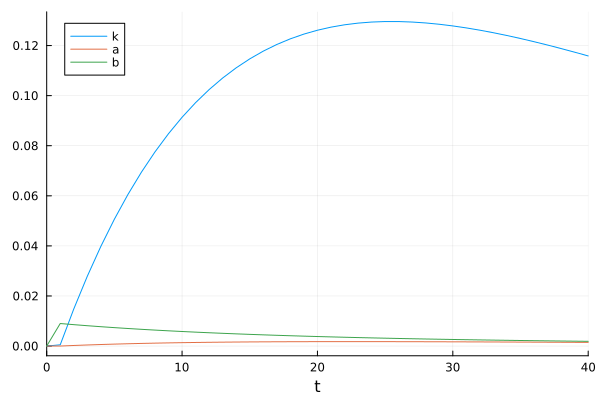

In [10]:
uirforder2 = irf(sol_2, ushock, T)
plot(uirforder2) #State variables only

In [11]:
upath = uirforder2.z #Full IRF for all 6 variables for u shock
epath = eirforder2.z; #Full IRF for all 6 variables for e shock

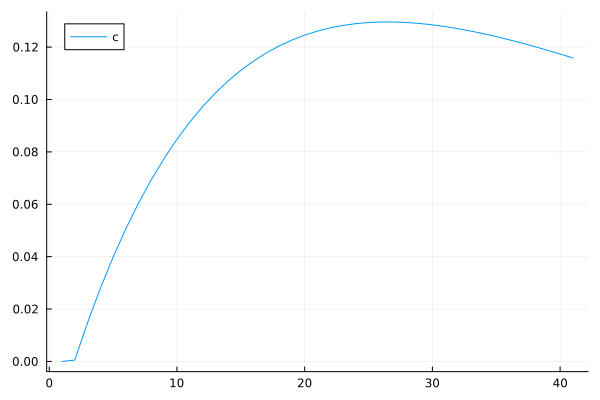

In [12]:
plot([epath[i][4] for i in 1:T+1],label="c")

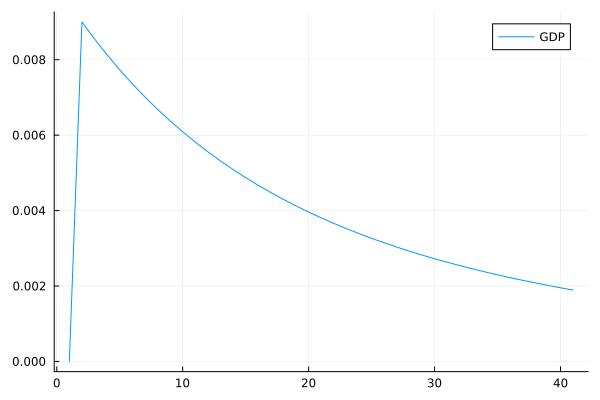

In [13]:
plot([epath[i][5] for i in 1:T+1],label="GDP")

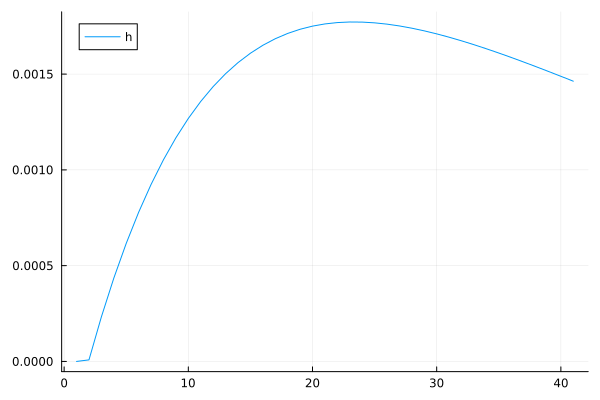

In [14]:
plot([epath[i][6] for i in 1:T+1],label="h")

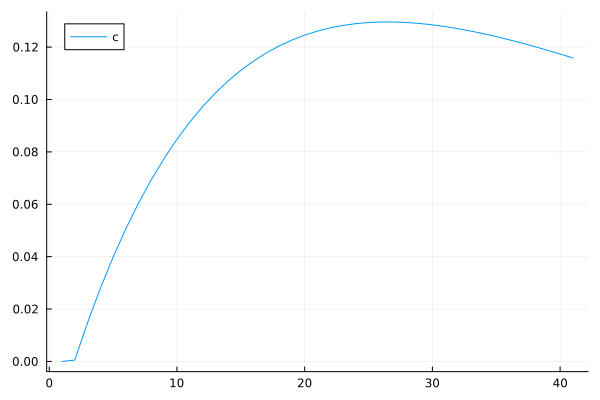

In [15]:
plot([upath[i][4] for i in 1:T+1],label="c")

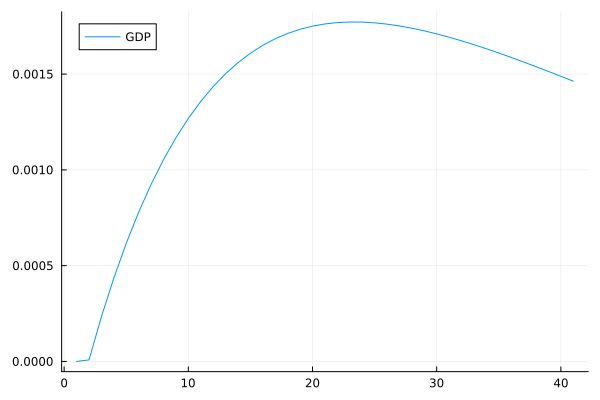

In [16]:
plot([upath[i][5] for i in 1:T+1],label="GDP")

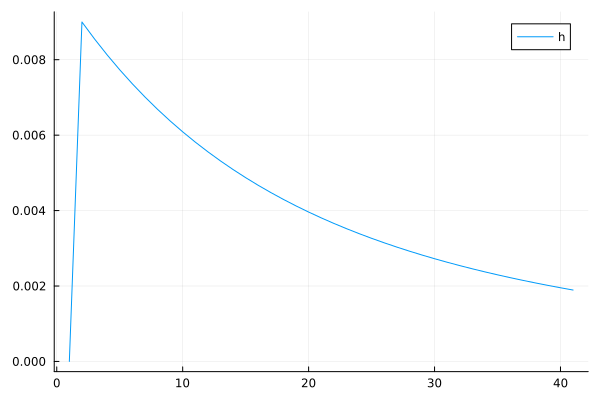

In [17]:
plot([upath[i][6] for i in 1:T+1],label="h")